# __Pré-traitement__ des données de profils d'aile
#### _Étude de profil d’aile d’avion par Machine Learning_ - _Université de Sherbrooke_
#### 
__Auteur__ : _Ilyas Baktache_  
__Année__ : 2022  
 

__Objectif__ : 




In [1]:
from application import *
import pickle

import pandas as pd
import seaborn as snc

# Paramétrisation de profil d'aile et réduction dimensionnelle

## Base de donnée de profils

On collecte les profils d'aile en scrappant le site _http://airfoiltools.com/_. On enregistre alors localement les données de profils.

In [4]:
all_airfoils = scrap.airfoils_name()
scrap.airfoils_coordinate(all_airfoils)

INFO:root:[11/10/2022 14:44:19] 1638(100%) airfoils coordinate were downloaded and saved locally


In [5]:
nb_airfoils = len(os.listdir(r"data/Airfoil_Coordinate"))
print("On obtient {} profils d'ailes dans notre base de donnée".format(nb_airfoils))

On obtient 1638 profils d'ailes dans notre base de donnée


On peut facilement visualiser l'un des profils de la base de données

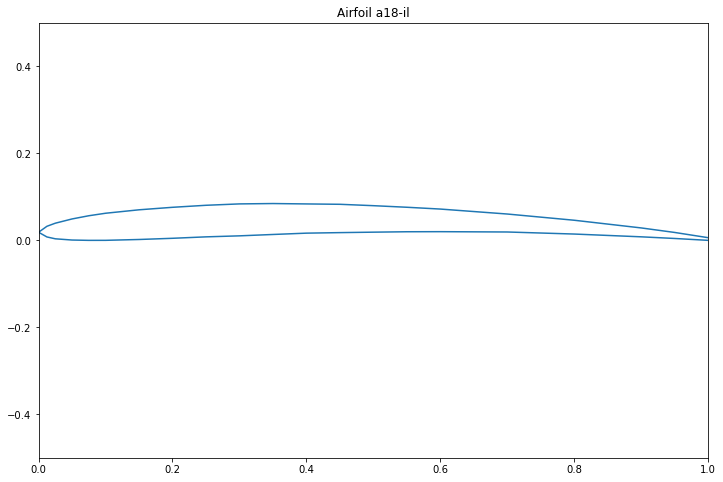

In [6]:
plot.airfoil('a18-il')

En supposant que chaque profil est représenté par p points de surface $(x_i, y_i)$, i = 1, . . . , p, les coordonnées y de chacun des n profils aérodynamiques de la base de données sont représentées sous la forme d'une matrice X de dimension n×p, 
$$
\begin{bmatrix}
y_{11} &y_{21}&...&y_{n1} \\
y_{12} &y_{22}&...&y_{n2} \\
... &...&...&... \\
... &...&...&... \\
y_{1p} &y_{2p}&...&y_{np} \\
\end{bmatrix}
$$
où: 
* n est le nombre de profils.
* p le nombre de variables les représentant. 

Dans notre cas, dependemment du profil le nombre de coordonnée p  varie de 24 à 260. On peut voir ici la répartition du nombre de coordonnées par profils:

Ainsi, on normalise et formatte toutes les données pour avoir un nombre de coordonnées similaire entre les différents profils. Pour des raisons de précision et à la suite de plusieurs tests, on choisit $\bf p = 118$. 

In [2]:
x,ally,nom_profil,marchepas = format.coordinate()
print("Pour des raisons divers, {} profils ne peuvent pas être utilisé dans notre etude.".format(len(marchepas)))
n = np.shape(ally)[1]
p = np.shape(ally)[0]
print("On obtient alors une matrice X de taille ({},{})".format(p,n))

Pour des raisons divers, 10 profils ne peuvent pas être utilisé dans notre etude.
On obtient alors une matrice X de taille (118,1628)


En choisissant un nombre de coordonnée fixe p, on a veillé à:
* Garder plus de point sur le leading edge et trailing edge
* Garder assez de point pour que le profil correspondent à l'original

Comme on peut le voir sur la figure suivante les deux conditions sont verfiées

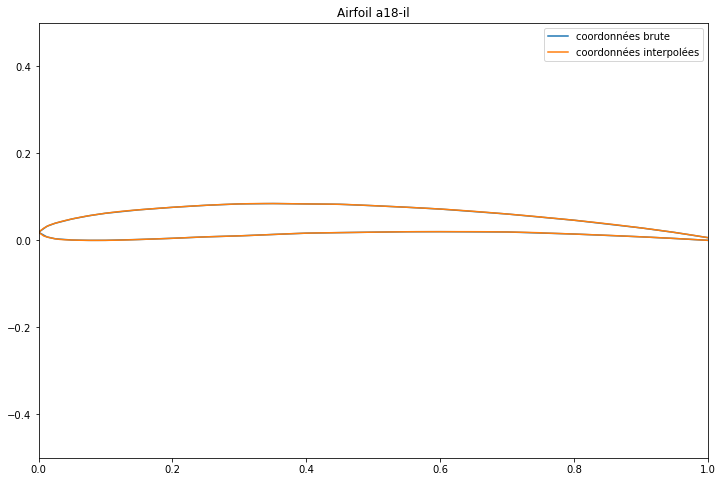

In [8]:
format.plot_airfoil('a18-il')

## Full Mode

### Reduction dimensionnelle

Ce nombre reste très grand. Ainsi, on cherche à réduire la dimensionalité des données, c'est-à-dire le nombre de variables utilisées pour les représenter pour :
* Faciliter la visualisation des données.
* Réduire les coûts de calcul, de stockage et d'acquisition des données.
* Améliorer l'apprentissage en construisant des modèles moins complexes, en éliminant les variables non pertinentes qui pourraient fausser les prédictions et enfin en réduisant le problème du fléau de la dimensionalité.

Nous allons étudier des techniques non-supervisées permettant de réduire ce nombre de variables. Il s'agira de trouver m variables, avec $m<p$  , que nous allons choisir d'utiliser pour construire une nouvelle matrice $\tilde{X}$ de dimension n×m pour représenter nos données. 

On utilise notamment la décompostion en valeurs singulières (ou SVD).
$$
X = U D V^T
$$

Avec: 
* $U$ Une matrice de taille (p,p) avec les vecteurs propres.
* $D$ Un vecteur (p,) avec les valeurs singulières, dans chaque vecteur trié par ordre décroissant. 
* $V$ est une matrice (n,n) dont les colonnes sont les vecteurs singuliers droits.

Les valeurs singulières de X, à savoir les élements de D, sont les racines carrées des valeurs propres de $Σ = XX^T$, tandis que les vecteurs singuliers de X sont les vecteurs propres de $Σ$ 


In [9]:
u, d,vh = np.linalg.svd(ally, full_matrices=True)

# On verfie que la decomposition en valeur singulières a été reussi
d_mat = np.zeros((p, n), dtype=complex)
d_mat[:p, :p] = np.diag(d)
np.allclose(ally, np.dot(u, np.dot(d_mat, vh)))

True

Pour l'instant la dimension de nos données reste inchangé. La méthode ci_dessus permet de construire autant de composantes principales que D a de vecteurs propres. Tous les modes propres ne sont pas nécessaire, pour choisir le nombre de mode propre utile, on utilise la proportion de variance expliquée (_PVE_) par chacune des composantes principales. La variance totale du jeu de donnée est données  par la somme des termes diagonaux du vecteur de covariance Σ qui sont les carrées des élement de D.
$$
PVE_k = \frac{\lambda_1 + \lambda_2 + ... + \lambda_k}{\lambda_1 + \lambda_2 + ... + \lambda_p}
$$

On trace alors le Scree plot qui montre comment cette proportion évolue en fonction du nombre de composantes k. 

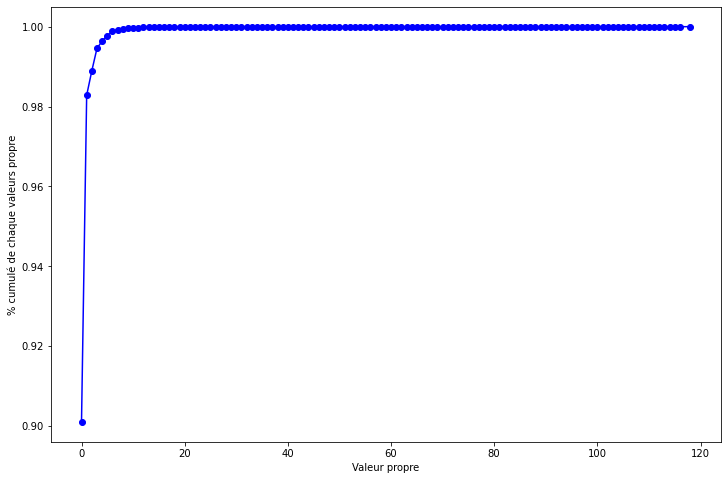

In [10]:
k = np.linspace(0,p,p,dtype=int)

plt.figure(figsize=(12,8))
plt.plot(k,cp.proportion_var(d,p),'b-o')
plt.xlabel('Valeur propre')
plt.ylabel('% cumulé de chaque valeurs propre')
plt.show()

On peut voir que les deux premières valeurs propres participent à  98% de la variance totale. On peut ainsi retenir uniquement celle-ci en projetant notre matrice X sur les deux premiers vecteurs propres associé à cette valeur propre:

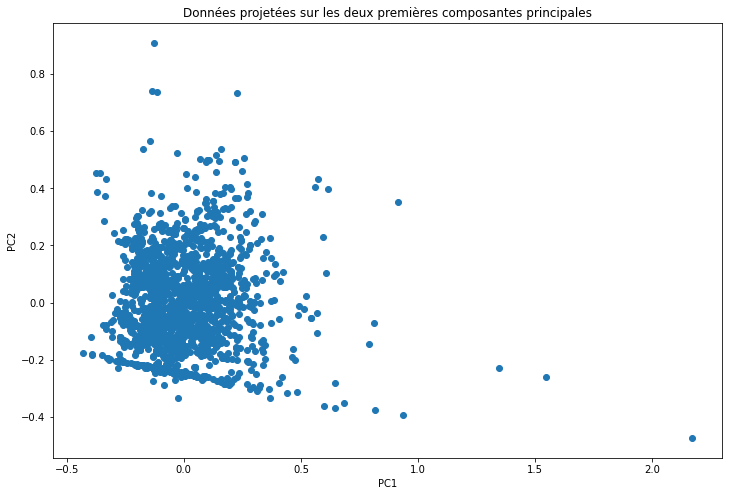

2.1686660070413923 -0.43060054718554014
0.9095510503379407 -0.4736335614671067


In [11]:
reduced_data = decomposition.PCA(n_components=2).fit_transform(ally.T) 
plt.figure(figsize=(12,8))
plt.title('Données projetées sur les deux premières composantes principales')
plt.scatter(reduced_data[:,0],reduced_data[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print(max(reduced_data[:,0]),min(reduced_data[:,0]))
print(max(reduced_data[:,1]),min(reduced_data[:,1]))

Il est difficile de comprendre dans notre cas l'utilité des ces deux composantes principale. Les profils de notre base de données sont tous fonctionnelle. Ainsi, on peut voir:
* La plupart des profils se situent sur -0.5<PC1<0.5 et -0.4<PC2<0.4. Ainsi, on peut rapidement tester un profil en prenant cette donnée comme base
* Certains profils se distingue sur cette projection. Ces profils sont probablement atypique du fait de leurs formes ou de leurs domaine d'application


On essaye maintenant de prendre 20 modes propres:

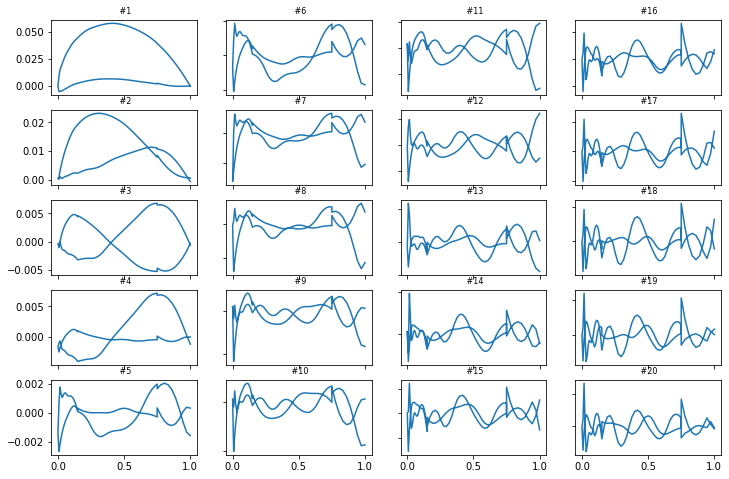

In [12]:
def modePropre(nb_pc):
    smat_v = np.zeros((p, n))
    smat_v[nb_pc:p, nb_pc:p] = np.diag(d[nb_pc:p])

    u_red = np.zeros((p, p))
    u_red[:,nb_pc:p] = u[:,nb_pc:p]

    ally_v = np.dot(u_red,np.dot(smat_v,vh))
    return ally_v

fig, axs = plt.subplots(5, 4,figsize= (12,8))
for k in range(4):
    for i in range(5):
        axs[i,k].plot(x,modePropre(5*k+i)[:,5])
        axs[i,k].set_title(' #{}'.format(5*k+i+1),fontdict = {'fontsize':8})

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


Ces modes propres ne nous donnes pas des informations facilement lisibles. On peut cependant distinguer la ligne de corde sur certain mode propre comme #7. Cette representation reste cependant plutot sommaire et illisible. 

## Modes lignes de cambure et épaisseur

Dans cette section, on aborde une autre approche pour carctériser un profil qui utilise les coordonnées y des lignes de cambrure et d'épaisseur. Ainsi, on déterminer les coordonnées des lignes de cambrure et d'épaisseur pour tous les profils: $ (x_i,y_{c_{i}},y_{t_{i}}) $ avec $i\in[1,p/2]$.De même que le mode complet:

$$ 
A_c = \begin{bmatrix}
y_{c_{11}} &y_{c_{21}}&...&y_{c_{n1}} \\
y_{c_{12}} &y_{c_{22}}&...&y_{c_{n2}} \\
... &...&...&... \\
... &...&...&... \\
y_{c_{1p/2}} &y_{c_{2p/2}}&...&y_{c_{np/2}} \\
\end{bmatrix} \hspace{1cm}
A_t = \begin{bmatrix}
y_{t_{11}} &y_{t_{21}}&...&y_{t_{n1}} \\
y_{t_{12}} &y_{t_{22}}&...&y_{t_{n2}} \\
... &...&...&... \\
... &...&...&... \\
y_{t_{1p/2}} &y_{t_{2p/2}}&...&y_{t_{np/2}} \\
\end{bmatrix}
$$
où: 
* n est le nombre de profils.
* p/2 le nombre de variables les représentant. 



In [13]:
x_ct, all_y_c , all_y_t, nom_profil, marchepas = format.camber_thick_coord(dir=r"data/Airfoil_Coordinate",nb_point = 30, nb_LE = 20, nb_TE = 10)
print("Pour des raisons divers, {} profils ne peuvent pas être utilisé dans notre etude.".format(len(marchepas)))
n_c = np.shape(all_y_c)[1]
n_t = np.shape(all_y_t)[1]
p_ct = np.shape(all_y_c)[0]
print(r"On obtient alors une matrice A_c de taille ({},{}) et une matrice A_t de taille ({},{})".format(p,n_c,p,n_t))

Pour des raisons divers, 10 profils ne peuvent pas être utilisé dans notre etude.
On obtient alors une matrice A_c de taille (118,1628) et une matrice A_t de taille (118,1628)


Les modes des lignes de cambrure et d'épaisseur sont également obtenu par SVD:

$$
A_c = U_c D_c V_c^{T} \hspace{1cm} A_t = U_t D_t V_t^{T}
$$

Avec: 
* $U_c$ et $U_t$ des matrices de taille (p,p) avec les vecteurs propres.
* $D_c$ et $D_t$ des vecteurs (p,) avec les valeurs singulières, dans chaque vecteur trié par ordre décroissant. 
* $V_c$ et $V_t$ des matrices (n/2,n/2) dont les colonnes sont les vecteurs singuliers droits.

In [14]:
u_c, d_c,vh_c = np.linalg.svd(all_y_c, full_matrices=True)

# On verfie que la decomposition en valeur singulières a été reussi
d_mat_c = np.zeros((p_ct, n_c), dtype=complex)
d_mat_c[:p_ct, :p_ct] = np.diag(d_c)
np.allclose(all_y_c, np.dot(u_c, np.dot(d_mat_c, vh_c)))

u_t, d_t,vh_t = np.linalg.svd(all_y_t, full_matrices=True)

# On verfie que la decomposition en valeur singulières a été reussi
d_mat_t = np.zeros((p_ct, n_t), dtype=complex)
d_mat_t[:p_ct, :p_ct] = np.diag(d_t)
np.allclose(all_y_t, np.dot(u_t, np.dot(d_mat_t, vh_t)))

True

Si  on cherche à exprimer les premiers $n_c$ et $n_t$ modes de cambrure et d'épaisseur, respectivement avec deux matrice:
$
U_c $ et $U_t
$

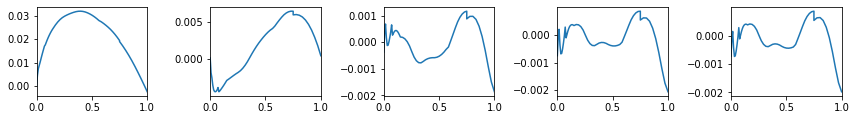

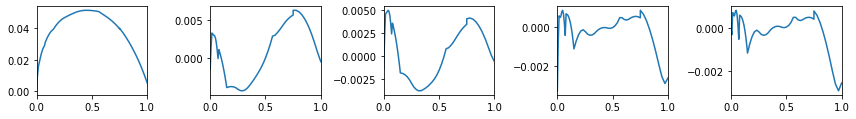

In [15]:
def modePropre_c(nb_pc):
    smat_v_c = np.zeros((p_ct, n_c))
    smat_v_c[nb_pc:p_ct, nb_pc:p_ct] = np.diag(d_c[nb_pc:p_ct])

    u_red_c = np.zeros((p_ct, p_ct))
    u_red_c[:,nb_pc:p_ct] = u_c[:,nb_pc:p_ct]

    ally_v_c = np.dot(u_red_c,np.dot(smat_v_c,vh_c))
    return ally_v_c

def modePropre_t(nb_pc):
    smat_v_t = np.zeros((p_ct, n_t))
    smat_v_t[nb_pc:p_ct, nb_pc:p_ct] = np.diag(d_t[nb_pc:p_ct])

    u_red_t = np.zeros((p_ct, p_ct))
    u_red_t[:,nb_pc:p_ct] = u_t[:,nb_pc:p_ct]

    ally_v_t = np.dot(u_red_t,np.dot(smat_v_t,vh_t))
    return ally_v_t

plt.figure(figsize = (12,8))
for k in range(5):  
    plt.subplot(551 + k )
    plt.xlim([0,1])
    plt.plot(x_ct,np.array(modePropre_c(k)[:,5])[:,0])
    
plt.tight_layout()
plt.figure(figsize = (12,8))
for k in range(5):  
    plt.subplot(551 + k )
    plt.xlim([0,1])
    plt.plot(x_ct,np.array(modePropre_t(k)[:,5])[:,0])
plt.tight_layout()




On peut essayer de verifier nos résulats en écrivant:
$$
Y = \begin{bmatrix}
y_{extrados}\\
y_{intrados}
\end{bmatrix}  = \begin{bmatrix}
\phi_c & \phi_t\\
\phi_c & -\phi_t
\end{bmatrix} \begin{bmatrix}
a_c\\
\frac{1}{2} a_t
\end{bmatrix} = U_{ct} d_{ct} V_{ct}^T
$$

Ainsi, on est censé obtenir les mêmes résultats que pour le mode complet. On essaye maintenant de prendre 20 modes propres:

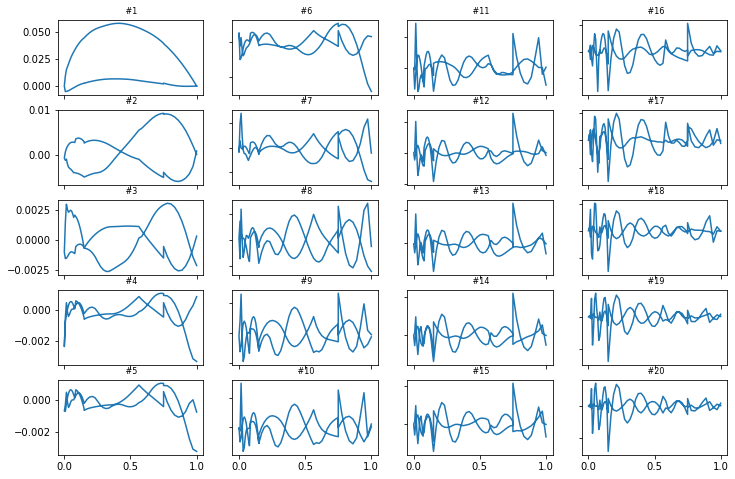

In [16]:
def modePropre_ct(nb_pc):
    smat_v_c = np.zeros((p_ct, n_c))
    smat_v_c[nb_pc:p_ct, nb_pc:p_ct] = np.diag(d_c[nb_pc:p_ct])

    smat_v_t = np.zeros((p_ct, n_t))
    smat_v_t[nb_pc:p_ct, nb_pc:p_ct] = np.diag(d_t[nb_pc:p_ct])

    smat_v_all = np.block([[np.dot(smat_v_c,vh_c)],[np.multiply(np.dot(smat_v_t,vh_t),1/2)]])

    u_red_c = np.zeros((p_ct, p_ct))
    u_red_c[:,nb_pc:p_ct] = u_c[:,nb_pc:p_ct]

    u_red_t = np.zeros((p_ct, p_ct))
    u_red_t[:,nb_pc:p_ct] = u_t[:,nb_pc:p_ct]

    u_red_all = np.block([[u_red_c,u_red_t],[u_red_c,-u_red_t]])

    ally_v = np.dot(u_red_all,smat_v_all)
    return ally_v

fig, axs = plt.subplots(5, 4,figsize= (12,8))
for k in range(4):
    for i in range(5):
        axs[i,k].plot(x,modePropre_ct(5*k+i)[:,5])
        axs[i,k].set_title(' #{}'.format(5*k+i+1),fontdict = {'fontsize':8})

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## Comparaison des deux modes 

On cherche à comparer les deux types de representation spatiale: 


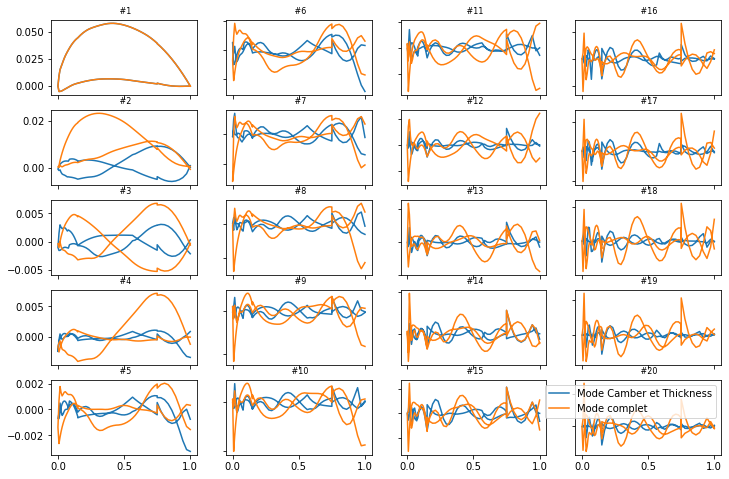

In [17]:
def modePropre_ct(nb_pc):
    smat_v_c = np.zeros((p_ct, n_c))
    smat_v_c[nb_pc:p_ct, nb_pc:p_ct] = np.diag(d_c[nb_pc:p_ct])

    smat_v_t = np.zeros((p_ct, n_t))
    smat_v_t[nb_pc:p_ct, nb_pc:p_ct] = np.diag(d_t[nb_pc:p_ct])

    smat_v_all = np.block([[np.dot(smat_v_c,vh_c)],[np.multiply(np.dot(smat_v_t,vh_t),1/2)]])

    u_red_c = np.zeros((p_ct, p_ct))
    u_red_c[:,nb_pc:p_ct] = u_c[:,nb_pc:p_ct]

    u_red_t = np.zeros((p_ct, p_ct))
    u_red_t[:,nb_pc:p_ct] = u_t[:,nb_pc:p_ct]

    u_red_all = np.block([[u_red_c,u_red_t],[u_red_c,-u_red_t]])

    ally_v = np.dot(u_red_all,smat_v_all)
    return ally_v

fig, axs = plt.subplots(5, 4,figsize= (12,8))
for k in range(4):
    for i in range(5):
        axs[i,k].plot(x,modePropre_ct(5*k+i)[:,5])
        axs[i,k].plot(x,modePropre(5*k+i)[:,5])
        axs[i,k].set_title(' #{}'.format(5*k+i+1),fontdict = {'fontsize':8})

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.legend(['Mode Camber et Thickness','Mode complet'],loc = 'best')

On peut voir que plus on augmente les modes des deux representations étudié plus celle-ci différent l'une de l'autre. 

On s'interesse à deux critères de comparaison entre ces modes:
* La couverture spatiale du mode
* La précision des modes par rapport aux données d'origine


Concernant la couverture spatiale du mode, il suffit de s'intéresser au rang des matrices $U$ et $U_{ct}$:
$$
\begin{cases}
& \text{rg}(U) = n\\
& \text{rg}(U_{ct}) = n_c + n_t
\end{cases}
$$

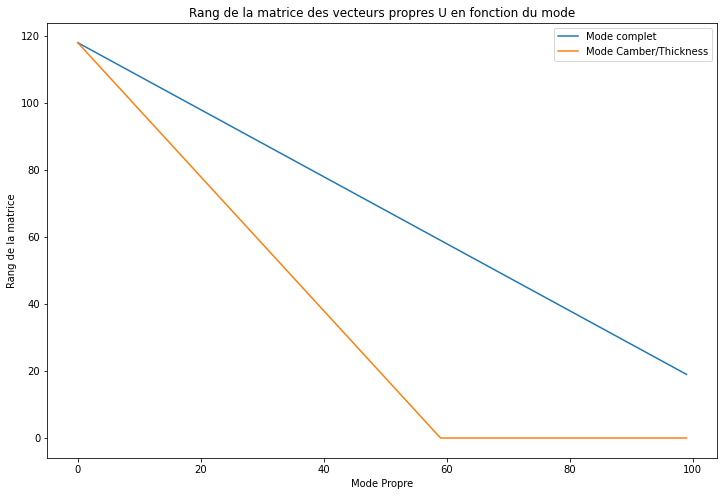

In [18]:
rg_all = []
rg_ct = []
for i in range(100):
    rg_all.append(lin.matrix_rank(modePropre(i)))
    rg_ct.append(lin.matrix_rank(modePropre_ct(i)))

plt.figure(figsize = (12,8))
plt.plot(rg_all,label = 'Mode complet')
plt.plot(rg_ct, label = 'Mode Camber/Thickness')
plt.xlabel("Mode Propre")
plt.ylabel("Rang de la matrice")
plt.title('Rang de la matrice des vecteurs propres U en fonction du mode')
plt.legend()
plt.show()

On peut voir que l'espace géométrique couvert par les mode complet est plus grand que celui couvert par les modes cambrure/épaisseur. Cet écart augmente grandement avec le nombre de mode choisis. On peut voir que pour un nombre de mode élevé (>55), les modes cambrure/épaisseur ne sont plus pertinent. 


On s'interesse maintenant à la précision des modes par rapport aux données d'origine. On définis alors une erreur absolue:
$$
\epsilon_p = \sum_{i=1}^{p}{\frac{||y^{i}_{orig}-y^{i}_{mode}||_{1}}{p||y^{i}_{orig}||_{1}}}
$$

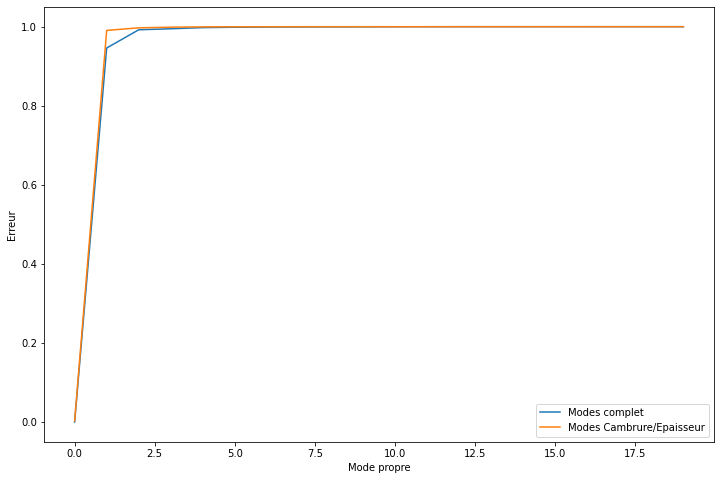

In [19]:
erreurs_ct = []
erreurs_all = []
list_indice = []
for k in range(20):
    list_indice.append(k)
    erreur_ct = 0
    erreur_all = 0
    for i in range(p):
        erreur_all += np.divide(lin.norm(np.subtract(ally[:,i],modePropre_ct(k)[:,i])),np.multiply(p,lin.norm(ally[:,i])))
        erreur_ct += np.divide(lin.norm(np.subtract(ally[:,i],modePropre(k)[:,i])),np.multiply(p,lin.norm(ally[:,i])))
    erreurs_ct.append(erreur_ct)
    erreurs_all.append(erreur_all)


plt.figure(figsize=(12,8))
plt.plot(list_indice,erreurs_ct,label = 'Modes complet')
plt.plot(list_indice,erreurs_all,label = 'Modes Cambrure/Epaisseur')
plt.xlabel("Mode propre")
plt.ylabel("Erreur")
plt.legend()
plt.show()

On peut voir que l'erreur obtenu est relativement haute et évolue grandement avec le nombre de mode voulu. Cependant le mode complet reste plus avantageux que le mode Cambrure/Epaisseur car il a une erreur plus faible. 

## Critère de sélection d’un profil aérodynamique

On cherche les critères de sélection d’un profil pour la conception d’un avion répondant à un certain cahier de charge. La polaire est une courbe qui qui fait correspondre les coefficients de traînée et de portance
déterminés pour différents angles d’incidence. Elle permet de mettre en évidences les points importants de performance de l’aile. 
![title](figure/schema_polaire.png)

On scrap les données du site _http://airfoiltools.com/_ pour obtenir les polaire de nos profils pour un nombre de Mach nulle et des nombres de Reynolds allant 50000 à 100000. 

In [47]:
le.allPolar(Re_list=[50000,100000,200000,500000,1000000],M_list=0)

INFO:root:[12/10/2022 09:48:55] Starting scrapping airfoils polar for M = 0 and Re = 50000
INFO:root:[12/10/2022 09:49:19] 1638(100%) airfoils polar for M = 0 and Re = 50000 were downloaded and saved locally
INFO:root:[12/10/2022 09:49:20] Starting scrapping airfoils polar for M = 0 and Re = 100000
INFO:root:[12/10/2022 09:49:43] 1638(100%) airfoils polar for M = 0 and Re = 100000 were downloaded and saved locally
INFO:root:[12/10/2022 09:49:44] Starting scrapping airfoils polar for M = 0 and Re = 200000
INFO:root:[12/10/2022 09:50:09] 1638(100%) airfoils polar for M = 0 and Re = 200000 were downloaded and saved locally
INFO:root:[12/10/2022 09:50:10] Starting scrapping airfoils polar for M = 0 and Re = 500000
INFO:root:[12/10/2022 09:50:33] 1638(100%) airfoils polar for M = 0 and Re = 500000 were downloaded and saved locally
INFO:root:[12/10/2022 09:50:34] Starting scrapping airfoils polar for M = 0 and Re = 1000000
INFO:root:[12/10/2022 09:50:58] 1638(100%) airfoils polar for M = 0 a

On calcule alors les différents profils, les points precisée ci-dessus

In [48]:
pD,pC,pA,pF,marchepas1 = critere.point_calc(nom_profil,0,50000,class1 = True,val = 'val')
dict['Point de décrochage'] = pD
dict['Point de chute min'] = pC 
dict["Point d'autonomie max"] = pA
dict["Point de distance franchissable max"] = pF


/Users/mac2021/Documents/Etude/Sherbrooke/Automne 2022/GMC809-Projet en génie aérospatial/airfoil_Optimisation_ML/data/scrapping.py:329: RuntimeWarning: invalid value encountered in power
  cD_cL_3_2 = cD/(cL**(3/2))
/Users/mac2021/Documents/Etude/Sherbrooke/Automne 2022/GMC809-Projet en génie aérospatial/airfoil_Optimisation_ML/data/scrapping.py:331: RuntimeWarning: invalid value encountered in sqrt
  cD_sqrtcL = cD/np.sqrt(cL)
/Users/mac2021/Documents/Etude/Sherbrooke/Automne 2022/GMC809-Projet en génie aérospatial/airfoil_Optimisation_ML/data/scrapping.py:329: RuntimeWarning: divide by zero encountered in true_divide
  cD_cL_3_2 = cD/(cL**(3/2))
/Users/mac2021/Documents/Etude/Sherbrooke/Automne 2022/GMC809-Projet en génie aérospatial/airfoil_Optimisation_ML/data/scrapping.py:331: RuntimeWarning: divide by zero encountered in true_divide
  cD_sqrtcL = cD/np.sqrt(cL)
INFO:root:Les points-critères de 4 profils n'ont pas pu être déterminé
